# Loading of Data and Libraries

## Importing Libraries and Packages

In [0]:
import pandas as pd
import string
import numpy as np
import tensorflow as tf
import time
import nltk
import matplotlib.pyplot as plt
import re

nltk.download('stopwords')
from nltk.corpus import stopwords

from keras.models import Sequential
from keras import initializers
from keras.layers import Dropout, Activation, Embedding, Convolution1D, GlobalAveragePooling1D, MaxPooling1D, Input, Dense, BatchNormalization, Flatten, Reshape, Concatenate
from keras.layers.recurrent import LSTM, GRU
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras import regularizers
from tensorflow.keras import datasets, layers, models

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import operator

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
kaggle_data = pd.read_csv('/content/drive/My Drive/BT4222/kaggle_labeled.csv')
original_data = pd.read_csv('/content/drive/My Drive/BT4222/kaggle_inter.csv')
crawled_tweets = pd.read_csv('/content/drive/My Drive/BT4222/cust_tweets.csv')

# Add Companies' Replies after the customers' tweets

In [0]:
customer_text_all = kaggle_data.loc[kaggle_data.tweet_from_company == 0]
customer_text_all = customer_text_all.loc[customer_text_all.response_ability_label == 1]

In [0]:
answerable_cust_id = customer_text_all.tweet_id

In [0]:
answerable_cust_id = {str(x) for x in answerable_cust_id}

In [0]:
company_replies = {}

In [0]:
for row_num in range(0, len(original_data)):
    inres_o = str(original_data.in_response_to_tweet_id.iloc[row_num])
    if inres_o == 'nan':
        inres = ''
    else:
        inres = str(int(original_data.in_response_to_tweet_id.iloc[row_num]))
    from_com = original_data.tweet_from_company.iloc[row_num]
    if inres in answerable_cust_id and from_com == 1 and inres not in company_replies:
        company_replies[inres] = original_data.text.iloc[row_num]
        

In [0]:
len(company_replies)

295252

In [0]:
company_replies_l = []

In [0]:
for row_num in range(0, len(kaggle_data)):
    tweetID = str(kaggle_data.tweet_id.iloc[row_num])
    anserable = kaggle_data.response_ability_label.iloc[row_num]
    if tweetID in company_replies and anserable == 1:
        company_replies_l.append(company_replies[tweetID])
    else:
        company_replies_l.append('No need company reply text')

In [0]:
print(len(company_replies_l))

590504


In [0]:
kaggle_data['company_reply_text'] = company_replies_l

# Pre-processing the data

In [0]:
kaggle_data

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,response_ability_label,tweet_from_company,company_reply_text
0,1881362,561461,True,Tue Oct 17 17:29:44 +0000 2017,@118424 The speed of your DATA can be compared...,1881361,1881363.0,1,0,"@561461 Hello, please be informed that data de..."
1,740989,297215,True,Wed Oct 11 13:58:30 +0000 2017,@AppleSupport 11,740991,740988.0,1,0,"@297215 So we can help further, can we have th..."
2,621080,267405,True,Wed Nov 22 15:50:26 +0000 2017,@GloCare Please could you help me with any app...,"621079,621081",621082.0,1,0,@267405 Kindly be more explicit. ET.
3,2235058,141913,True,Sat Nov 11 08:21:51 +0000 2017,@Safaricom_Care DM (1),2235060,2235057.0,1,0,@141913 On it. ^KD
4,2163052,390852,True,Thu Nov 09 07:48:00 +0000 2017,"@LondonMidland hello, long queue at Worcester ...",2163051,NaN,1,0,@390852 I can pass the information on I'd advi...
...,...,...,...,...,...,...,...,...,...,...
590499,2987924,823860,True,Wed Nov 29 22:31:37 +0000 2017,@ArgosHelpers ordered items for same day deliv...,2987923,NaN,0,0,No need company reply text
590500,2987934,823864,True,Thu Nov 30 01:40:49 +0000 2017,"Second day (night) in a row my package is ""on ...","2987935,2987933",NaN,0,0,No need company reply text
590501,2987937,823865,True,Thu Nov 30 01:39:12 +0000 2017,@115817 @UPSHelp Why does the tracking record ...,2987936,NaN,0,0,No need company reply text
590502,2987942,823867,True,Wed Nov 22 07:30:39 +0000 2017,Hai @AirAsiaSupport #asking how many days need...,2987941,NaN,0,0,No need company reply text


In [0]:
crawled_tweets.shape

(7643, 8)

In [0]:
crawled_tweets = crawled_tweets.drop(['Unnamed: 0'], axis = 1)
crawled_tweets = crawled_tweets.rename(columns={"authod_id": 'author_id'})

Check for NaN values 

In [0]:
start_time = time.time()

clean_kaggle = kaggle_data.dropna(thresh=2)
clean_tweets = crawled_tweets.dropna(thresh=2)

print("--- %s seconds ---" % (time.time() - start_time))

--- 1.227508306503296 seconds ---


In [0]:
print(clean_kaggle.shape)
print(clean_tweets.shape)

(590504, 10)
(7643, 7)


Remove links from Text

In [0]:
def remove_links(text):
  text = re.sub(r"http\S+", "", text)
  return text

In [0]:
start_time = time.time()

clean_kaggle['text'] = clean_kaggle.text.apply(str)
clean_kaggle['company_reply_text'] = clean_kaggle.company_reply_text.apply(str)
clean_tweets['text'] = clean_tweets.text.apply(str)

clean_kaggle['CleanedText'] = clean_kaggle.text.apply(remove_links)
clean_kaggle['Cleanedcompany_reply_text'] = clean_kaggle.company_reply_text.apply(remove_links)
clean_tweets['CleanedText'] = clean_tweets.text.apply(remove_links)

print("--- %s seconds ---" % (time.time() - start_time))

--- 1.9373044967651367 seconds ---


Remove twitter account handles from CleanedText

In [0]:
def remove_username(text):
  #text = re.sub(r'@[A-Za-z0-9]+','', text)
  text = re.sub(r"(?:\@|https?\://)\S+", '', text)
  return text


In [0]:
start_time = time.time()

clean_kaggle['CleanedText'] = clean_kaggle.CleanedText.apply(remove_username)
clean_kaggle['Cleanedcompany_reply_text'] = clean_kaggle.company_reply_text.apply(remove_username)
clean_tweets['CleanedText'] = clean_tweets.CleanedText.apply(remove_username)

print("--- %s seconds ---" % (time.time() - start_time))

--- 2.9423177242279053 seconds ---


In [0]:
clean_kaggle.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,response_ability_label,tweet_from_company,company_reply_text,CleanedText,Cleanedcompany_reply_text
0,1881362,561461,True,Tue Oct 17 17:29:44 +0000 2017,@118424 The speed of your DATA can be compared...,1881361,1881363.0,1,0,"@561461 Hello, please be informed that data de...",The speed of your DATA can be compared to tha...,"Hello, please be informed that data depletion..."
1,740989,297215,True,Wed Oct 11 13:58:30 +0000 2017,@AppleSupport 11,740991,740988.0,1,0,"@297215 So we can help further, can we have th...",11,"So we can help further, can we have the exact..."
2,621080,267405,True,Wed Nov 22 15:50:26 +0000 2017,@GloCare Please could you help me with any app...,"621079,621081",621082.0,1,0,@267405 Kindly be more explicit. ET.,Please could you help me with any app name?,Kindly be more explicit. ET.
3,2235058,141913,True,Sat Nov 11 08:21:51 +0000 2017,@Safaricom_Care DM (1),2235060,2235057.0,1,0,@141913 On it. ^KD,DM (1),On it. ^KD
4,2163052,390852,True,Thu Nov 09 07:48:00 +0000 2017,"@LondonMidland hello, long queue at Worcester ...",2163051,NaN,1,0,@390852 I can pass the information on I'd advi...,"hello, long queue at Worcester Shrub Hill as ...",I can pass the information on I'd advise spea...


In [0]:
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)

In [0]:
start_time = time.time()

#removing handles
clean_kaggle['CleanerText'] = clean_kaggle.CleanedText.apply(tknzr.tokenize)
clean_kaggle['Cleanedcompany_reply_text'] = clean_kaggle.company_reply_text.apply(tknzr.tokenize)
clean_tweets['CleanerText'] = clean_tweets.CleanedText.apply(tknzr.tokenize)

print("--- %s seconds ---" % (time.time() - start_time))

--- 76.19811153411865 seconds ---


In [0]:
clean_tweets

,tweet_id,author_id,inbound,created_at,text,in_response_to_tweet_id,customers_of,CleanedText,CleanerText
0,1249193154512916480,375541562,False,2020-04-12 04:30:31,@Jetstar_Asia Please check your DM. Thanks @Je...,1.249190e+18,JetStar Asia,Please check your DM. Thanks,"[Please, check, your, DM, ., Thanks]"
1,1249189062759665667,375541562,False,2020-04-12 04:14:16,@Jetstar_Asia Pleas help me. I have also tried...,1.249186e+18,JetStar Asia,Pleas help me. I have also tried calling seve...,"[Pleas, help, me, ., I, have, also, tried, cal..."
2,1249040470401060864,1024338385404682246,True,2020-04-11 18:23:48,RT @monilsj: Hi @Jetstar_Asia! I have noticed ...,NaN,JetStar Asia,RT Hi I have noticed that Air Asia and more ...,"[RT, Hi, I, have, noticed, that, Air, Asia, an..."
3,1249038696214458369,286610770,True,2020-04-11 18:16:45,Hi @Jetstar_Asia! I have noticed that Air Asia...,NaN,JetStar Asia,Hi I have noticed that Air Asia and more rece...,"[Hi, I, have, noticed, that, Air, Asia, and, m..."
4,1248566696798867456,1048797604019036160,True,2020-04-10 11:01:12,RT @RayMSLim: @Jetstar_Asia why do you make it...,NaN,JetStar Asia,RT why do you make it so difficult to apply ...,"[RT, why, do, you, make, it, so, difficult, to..."
...,...,...,...,...,...,...,...,...,...
7638,1246335441596321793,122037642,False,2020-04-04 07:14:59,@CebuPacificAir Where is your DM? https://t.co...,1.246197e+18,Cebu Pacific Air,Where is your DM?,"[Where, is, your, DM, ?]"
7639,1246334892729708545,122037642,False,2020-04-04 07:12:48,@iseemelons @CebuPacificAir No you DID NOT!,1.246201e+18,Cebu Pacific Air,No you DID NOT!,"[No, you, DID, NOT, !]"
7640,1246334331590598656,1246263403930193920,False,2020-04-04 07:10:35,@CebuPacificAir How to refund my additional ba...,1.242433e+18,Cebu Pacific Air,How to refund my additional baggage that I av...,"[How, to, refund, my, additional, baggage, tha..."
7641,1246333808573464576,211427232,True,2020-04-04 07:08:30,"Hi @CebuPacificAir, havent received a reply to...",NaN,Cebu Pacific Air,Hi havent received a reply to my DM since las...,"[Hi, havent, received, a, reply, to, my, DM, s..."


# Model 1 : Classification Model
Based on CleanerText and response_ability_label, predict the model's accuracy in predicting whether a customer's tweet can be answered and resolved without the need to DM customer service.

In [0]:
# Defining general parameters

NUM_WORDS = 20000
SEQ_LEN = 200
EMBEDDING_SIZE = 256
BATCH_SIZE = 512
EPOCHS = 10
THRESHOLD=0.5

In [0]:
#splitting the data

X_data = clean_kaggle['CleanedText']
y_data = clean_kaggle['response_ability_label']

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state = 2)

In [0]:
#create tokenizer for our data
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=NUM_WORDS, oov_token='<UNK>')
tokenizer.fit_on_texts(X_train)

#convert text data to numerical indexes
train_seqs=tokenizer.texts_to_sequences(X_train)
test_seqs=tokenizer.texts_to_sequences(X_test)

#pad data up to SEQ_LEN (note that we truncate if there are more than SEQ_LEN tokens)
train_seqs=tf.keras.preprocessing.sequence.pad_sequences(train_seqs, maxlen=SEQ_LEN, padding="post")
test_seqs=tf.keras.preprocessing.sequence.pad_sequences(test_seqs, maxlen=SEQ_LEN, padding="post")

## Generating the model

### Model 1: Embedding + Global Average Pooling + Dense Layer

In [0]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(NUM_WORDS, EMBEDDING_SIZE),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dense(1, activation='sigmoid')])

model.summary()

#use of default parameters, can be changed for further experimentation
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#including an early stopping function to prevent overfitting of data during training
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max')

callbacks=[es]

history = model.fit(train_seqs, y_train
                    , batch_size=BATCH_SIZE
                    , epochs=EPOCHS
                    , validation_split=0.2
                    , callbacks=callbacks
                    )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 256)         5120000   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 5,120,257
Trainable params: 5,120,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
739/739 [==============================] - 89s 120ms/step - loss: 0.6599 - accuracy: 0.6103 - val_loss: 0.6304 - val_accuracy: 0.6528
Epoch 2/10
739/739 [==============================] - 89s 120ms/step - loss: 0.6166 - accuracy: 0.6632 - val_loss: 0.6141 - val_accuracy: 0.6627
Epoch 3/10
739/739 [==============================] - 90s 121ms/step - loss: 0.6034 

In [0]:
# Evaluate the model with the test result
model.evaluate(test_seqs, y_test)

3691/3691 [==============================] - 8s 2ms/step - loss: 0.6096 - accuracy: 0.6609


[0.6095987558364868, 0.6609427332878113]

### Model 2: Embedding + Dense + Global Average Pooling + Dense

In [0]:
# Model Building
def train_model(Optimizer, X_train, y_train): #, X_val, y_val
    
    # We are defining sequential class from keras.models import Squential.
    model = Sequential()
    
    # We are embedding layer from keras.layers import Embedding.
    # input_dim is the same with num_words parameter. It sets up the maximum number of unique words.
    # output_dim is the hyperparameter to be fine-tuned.
    model.add(Embedding(input_dim = 50000, output_dim = 256))
   
    # We are implementing LSTM layer from keras.layers import LSTM.
    # units represents the number of recurring units. A larger number of units results in a more complex model.
    #model.add(LSTM(units=256))
    
    # We are adding a dense layer to ensure that the output ranges from 0 and 1.
    #model.add(GlobalAveragePooling1D())
    model.add(Dense(5, activation='relu')) 
    model.add(GlobalAveragePooling1D())
    model.add(Dense(1, activation='sigmoid'))

    # You can check the final layer in your model.
    model.summary()
    
    #including an early stopping function to prevent overfitting of data during training
    es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max')

    callbacks=[es]

    # We are complining the model. The loss function is for the binary output.
    model.compile(loss='binary_crossentropy', optimizer = Optimizer, metrics=['accuracy'])
    scores = model.fit(X_train, y_train, batch_size=1024, epochs=10,validation_split=0.2, callbacks=callbacks) # validation_data=(X_val, y_val)
    return scores, model

In [0]:
adam_score, adam_model = train_model(Optimizer = 'adam', X_train=train_seqs, y_train=y_train) # X_val=test_seqs, y_val=y_test

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 256)         12800000  
_________________________________________________________________
dense_1 (Dense)              (None, None, 5)           1285      
_________________________________________________________________
global_average_pooling1d_1 ( (None, 5)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 12,801,291
Trainable params: 12,801,291
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 377922 samples, validate on 94481 samples
Epoch 1/10
377922/377922 [==============================] - 148s 393us/step - loss: 0.6628 - accuracy: 0.6126 - val_loss: 0.6273 - val_accuracy: 0.6544
Epoch 2/10
377922/377922 [==============================] - 147s 390us/step - loss: 0.6115 - accuracy: 0.6700 - val_loss: 0.6108 - val_accuracy: 0.6702
Epoch 3/10
377922/377922 [==============================] - 148s 392us/step - loss: 0.5984 - accuracy: 0.6811 - val_loss: 0.6070 - val_accuracy: 0.6738
Epoch 4/10
377922/377922 [==============================] - 148s 391us/step - loss: 0.5921 - accuracy: 0.6852 - val_loss: 0.6064 - val_accuracy: 0.6744
Epoch 5/10
377922/377922 [==============================] - 147s 390us/step - loss: 0.5880 - accuracy: 0.6881 - val_loss: 0.6067 - val_accuracy: 0.6740


In [0]:
#Evaluate the adam model
adam_model.evaluate(test_seqs, y_test)

118101/118101 [==============================] - 8s 71us/step


[0.6061393265856876, 0.6702144742012024]

In [0]:
RMSprop_score, RMSprop_model = train_model(Optimizer = 'RMSprop', X_train=train_seqs, y_train=y_train) #, X_val=test_seqs, y_val=y_test

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 256)         12800000  
_________________________________________________________________
dense_3 (Dense)              (None, None, 5)           1285      
_________________________________________________________________
global_average_pooling1d_2 ( (None, 5)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6         
Total params: 12,801,291
Trainable params: 12,801,291
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 377922 samples, validate on 94481 samples
Epoch 1/10
377922/377922 [==============================] - 138s 364us/step - loss: 0.6657 - accuracy: 0.6254 - val_loss: 0.6360 - val_accuracy: 0.6486
Epoch 2/10
377922/377922 [==============================] - 136s 361us/step - loss: 0.6185 - accuracy: 0.6644 - val_loss: 0.6171 - val_accuracy: 0.6646
Epoch 3/10
377922/377922 [==============================] - 137s 362us/step - loss: 0.6051 - accuracy: 0.6752 - val_loss: 0.6122 - val_accuracy: 0.6682
Epoch 4/10
377922/377922 [==============================] - 137s 363us/step - loss: 0.5992 - accuracy: 0.6794 - val_loss: 0.6102 - val_accuracy: 0.6694
Epoch 5/10
377922/377922 [==============================] - 137s 363us/step - loss: 0.5957 - accuracy: 0.6823 - val_loss: 0.6094 - val_accuracy: 0.6701
Epoch 6/10
377922/377922 [==============================] - 137s 362us/step - loss: 0.5933 - accuracy: 0.6837 - val_loss: 0.6096 - val_accuracy: 0.6703
Epoch 7/10
377922/377922 [===========

In [0]:
#Evaluate the RMSprop model
RMSprop_model.evaluate(test_seqs, y_test)

118101/118101 [==============================] - 9s 74us/step


[0.608913219285907, 0.6679367423057556]

# Model 2: Unsupervised Learning (K-Means)
Based on customers' tweets, we can get a sensing of the questions being asked and the overall theme for the cluster in hopes of generating an appropriate response.

In [0]:
def removing_punct(text):
      return text.translate(str.maketrans('','',string.punctuation))

In [0]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [0]:
def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'0,0', '00', text) 
    text = re.sub(r'[_"\-;%()|.,+&=*%.,!?:#@\[\]]', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\$', ' $ ', text)
    text = re.sub(r'u s ', ' united states ', text)
    text = re.sub(r'u n ', ' united nations ', text)
    text = re.sub(r'u k ', ' united kingdom ', text)
    text = re.sub(r'j k ', ' jk ', text)
    text = re.sub(r' s ', ' ', text)
    text = re.sub(r' yr ', ' year ', text)
    text = re.sub(r' l g b t ', ' lgbt ', text)
    text = re.sub(r'0km ', '0 km ', text)
    text = re.sub(r'http ', '', text)
    text = re.sub(r'https ', '', text)
    text = re.sub(r'hi ', '', text)
    text = re.sub(r'hello ', '', text)
    text = re.sub(r'sorry ', '', text)
    text = re.sub(r'thanks ', '', text)
    text = re.sub(r'thank ', '', text)
    text = re.sub(r'ty ', '', text)
    text = re.sub(r'll ', '', text)
    text = re.sub(r'RT ', '', text)
    text = re.sub(r've ', '', text)
    text = re.sub(r'us ', '', text)
    text = re.sub(r'please ', '', text)
    
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)
    
    return text

Since tweets with response_ability_label = 1 represents customers' tweets that can be answered, we will be focusing on the clustering for this group of tweets.

In [0]:
answerable_df = clean_kaggle[clean_kaggle['response_ability_label'] == 1]

In [0]:
answerable_df.shape

(295252, 13)

In [0]:
answerable_text = answerable_df['CleanedText'].apply(clean_text)

In [0]:
vec = TfidfVectorizer(stop_words='english')
vec.fit(answerable_text)
features = vec.transform(answerable_text)

## K-Means

In [0]:
start_time = time.time()

#estimated running time :30 mins - 1 hour
sum_of_squared_distances = []
K = range(1, 30)
for k in K:
    km = KMeans(n_clusters=k, init='k-means++', max_iter=5, n_init=5)
    km = km.fit(features)
    sum_of_squared_distances.append(km.inertia_)
    

print("--- %s seconds ---" % (time.time() - start_time))

--- 2295.763191461563 seconds ---


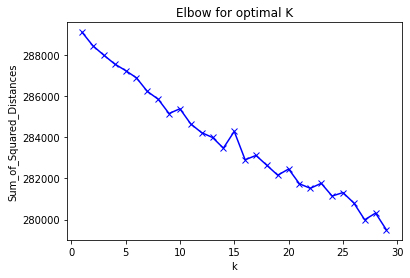

In [0]:
import matplotlib.pyplot as plt
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_Squared_Distances')
plt.title('Elbow for optimal K')
plt.show()

In [0]:
start_time = time.time()

#estimated running time :30 mins
true_k = 16
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=300, n_init=10)
model.fit(features)

print("--- %s seconds ---" % (time.time() - start_time))

In [0]:
print("Top terms per cluster by customers' tweets:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vec.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    cluster_names = []
    for ind in order_centroids[i, :15]:
      cluster_names.append(terms[ind])
        #print(' %s' % terms[ind]),
    print (cluster_names)

In [0]:
model.labels_

array([ 7, 12, 14, ...,  7,  8,  0], dtype=int32)

In [0]:
len(model.labels_)

295252

In [0]:
answerable_df['cluster_id'] = model.labels_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# Exploring how companies reply to different clusters
  #### Find the replies within each clusters to identify common terms

In [0]:
answerable_df

In [0]:
companies_reply = answerable_df[['Cleanedcompany_reply_text','cluster_id']]

In [0]:
replies_in_each_cluster = {}

In [0]:
for row in range(0, len(companies_reply)):
    cluster = companies_reply.cluster_id.iloc[row]
    text = companies_reply.Cleanedcompany_reply_text.iloc[row]
    text_str = ''
    for i in text:
        text_str = text_str + ' ' + i
    if cluster in replies_in_each_cluster:
        replies_in_each_cluster[cluster].append(text_str)
    else:
        replies_in_each_cluster[cluster] = []
        replies_in_each_cluster[cluster].append(text_str)

In [0]:
replies_in_each_cluster[4]

#### Roughly Analyze the company replies in each clusters -- How the compnies response to the customers in clusters

Cleaning the company replies

In [0]:
def remove_puncutation(text):
    new_text = ''
    for i in range(0, len(text)):
        if text[i] in string.punctuation:
            if i-1>=0 and text[i-1] == " ":
                new_text += ""
            else:
                new_text += " "
        else:
            new_text+=text[i]
    return new_text

In [0]:
def clean_text_company(text):
    # lower text
    text = text.lower()

    # Replace contractions with their longer forms 
    if True:
      text = text.split()
      new_text = []
      for word in text:
          if word in contractions:
              new_text.append(contractions[word])
          else:
              new_text.append(word)
      text = " ".join(new_text)

    # remove links and reformat words
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'0,0', '00', text) 
    text = re.sub(r'[_"\-;%()|.,+&=*%.,!?:#@\[\]]', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\$', ' $ ', text)
    text = re.sub(r'u s ', ' united states ', text)
    text = re.sub(r'u n ', ' united nations ', text)
    text = re.sub(r'u k ', ' united kingdom ', text)
    text = re.sub(r'j k ', ' jk ', text)
    text = re.sub(r' s ', ' ', text)
    text = re.sub(r' yr ', ' year ', text)
    text = re.sub(r' l g b t ', ' lgbt ', text)
    text = re.sub(r'0km ', '0 km ', text)
    text = re.sub(r'http ', '', text)
    text = re.sub(r'https ', '', text)
    text = re.sub(r'hi ', '', text)
    text = re.sub(r'hello ', '', text)
    text = re.sub(r'hey ', '', text)
    text = re.sub(r'sorry ', '', text)
    text = re.sub(r'thanks ', '', text)
    text = re.sub(r'thank ', '', text)
    text = re.sub(r'ty ', '', text)
    text = re.sub(r'll ', '', text)
    text = re.sub(r'RT ', '', text)
    text = re.sub(r've ', '', text)
    text = re.sub(r'us ', '', text)
    text = re.sub(r'please ', '', text)
    
    # remove @ inside text
    text = [word for word in text.split(" ")]
    text = [x for x in text if "@" not in x]
    # tokenize text and remove puncutation
    text = " ".join(text)
    text = remove_puncutation(text)
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

In [0]:
replies_in_each_cluster_words = {}

In [0]:
start_time = time.time()

for cluster in replies_in_each_cluster:
    reply_list_incluster = replies_in_each_cluster[cluster]
    reply_list_incluster_clean = ''
    for text in reply_list_incluster:
        cleaned = clean_text_company(text)
        reply_list_incluster_clean = reply_list_incluster_clean + ' ' + cleaned
    replies_in_each_cluster_words[cluster] = reply_list_incluster_clean

print("--- %s seconds ---" % (time.time() - start_time))

--- 867.7435204982758 seconds ---


In [0]:
replies_in_each_cluster_words[1]

' litv add able watch screens time xbox one errors pop worries ever need anything else shout wicome running px want help hayou tried steps could clarify platform vh want help temore experiencing bluetooth connectiviand iphone georgia aware issue reported apologies inconvenience temore exact issue experiencing released ios today sure back device update latest version teif helps issue change setting device management section pc co everything checks betting quick reset wido trick unplug device modem minutes retest would like look could tewhich version ios running experiencing issue anotifications certain ones want help using ios going iphone hadetails assist better let get done da getting error messages also troubleshooting steps hayou done far anthony gal link let know helps help info visit article steps may able help investigate click ca ja see moved tomorrow morning take look stay date catalogue number said key box tilly richard sure thing go settings general software update download l

Count the frequency of words

In [0]:
words_frequency = {}

In [0]:
for cluster in replies_in_each_cluster_words:
    words_frequency[cluster] = {}
    full_text = replies_in_each_cluster_words[cluster]
    text_list = [word for word in full_text.split(" ")]
    for word in text_list:
        if word not in words_frequency[cluster]:
            words_frequency[cluster][word] = 1
        else:
            words_frequency[cluster][word] += 1
    words_freq = sorted(words_frequency[cluster].items(), key=operator.itemgetter(1),reverse=True)
    words_frequency[cluster] = words_freq

In [0]:
words_frequency[0]

In [0]:
print ("Top terms in replies by companies for each cluster:")
for i in range(0, 16):
  print("Cluster %d:" % i)
  reply_terms = list((term[0] for term in words_frequency[i] if term[1]>=250))
  if (len(reply_terms) > 20):
    print(reply_terms[0:20])
  else:
    print(reply_terms)
  

Top terms in replies by companies for each cluster:
Cluster 0:
['flight', 'hear', 'team', 'number', 'dm', 'know', 'time', 'great', 'hope', 'soon', 'glad', 'see', 'wibe', 'happy', 'delay', 'get', 'would', 'look', 'haa', 'confirmation']
Cluster 1:
['issue', 'help', 'let', 'update', 'app', 'know', 'would', 'work', 'device', 'dm', 'fixed', 'software', 'future', 'around', 'address', 'look', 'account', 'issues', 'team', 'email']
Cluster 2:
['help', 'would', 'dm', 'hear', 'know', 'let', 'team', 'like', 'look', 'time', 'account', 'number', 'address', 'email', 'service', 'issue', 'wibe', 'get', 'see', 'apologies']
Cluster 3:
['help', 'would', 'know', 'hear', 'let', 'team', 'email', 'order', 'like', 'look', 'dm', 'details', 'account', 'address', 'contact', 'check', 'get', 'information', 'number', 'glad']
Cluster 4:
['help', 'dm', 'address', 'email', 'let', 'would', 'account', 'know', 'look', 'number', 'hear', 'try', 'issue', 'team', 'get', 'assist', 'check', 'hayou', 'contact', 'like']
Cluster 5

## Running it against the Crawled Tweets Dataset

In [0]:
def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'0,0', '00', text) 
    text = re.sub(r'[_"\-;%()|.,+&=*%.,!?:#@\[\]]', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\$', ' $ ', text)
    text = re.sub(r'u s ', ' united states ', text)
    text = re.sub(r'u n ', ' united nations ', text)
    text = re.sub(r'u k ', ' united kingdom ', text)
    text = re.sub(r'j k ', ' jk ', text)
    text = re.sub(r' s ', ' ', text)
    text = re.sub(r' yr ', ' year ', text)
    text = re.sub(r' l g b t ', ' lgbt ', text)
    text = re.sub(r'0km ', '0 km ', text)
    text = re.sub(r'http ', '', text)
    text = re.sub(r'https ', '', text)
    text = re.sub(r'hi ', '', text)
    text = re.sub(r'hello ', '', text)
    text = re.sub(r'sorry ', '', text)
    text = re.sub(r'thanks ', '', text)
    text = re.sub(r'thank ', '', text)
    text = re.sub(r'ty ', '', text)
    text = re.sub(r'll ', '', text)
    text = re.sub(r'RT ', '', text)
    text = re.sub(r've ', '', text)
    text = re.sub(r'us ', '', text)
    text = re.sub(r'please ', '', text)
    
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)
    
    return text

In [0]:
twitter_text = clean_tweets['text'].apply(clean_text)

In [0]:
twt_vec = TfidfVectorizer(stop_words='english')
twt_vec.fit(twitter_text)
twt_features = vec.transform(twitter_text)

In [0]:
def CountFrequency(my_list): 
    # Creating an empty dictionary  
    freq = {} 
    for item in my_list: 
        if (item in freq): 
            freq[item] += 1
        else: 
            freq[item] = 1

In [0]:
pred = model.predict(twt_features)

In [0]:
pred

array([15, 10,  7, ...,  7, 15,  7], dtype=int32)

In [0]:
fit_pred = model.fit_predict(twt_features)

In [0]:
pred_twt = CountFrequency(pred)
fit_pred_twt = CountFrequency(fit_pred)

In [0]:
print(pred_twt)

None


In [0]:
#using cluster 0 as shown in the report
clean_tweets['predict'] = model.predict(twt_features)
#clean_tweets['fit_predict'] = model.fit_predict(twt_features)

In [0]:
count = 0
for i in clean_tweets['predict']:
  if (i == 0):
    count += 1
  else:
    continue


In [0]:
print(count)

1551


In [0]:
print(count/len(clean_tweets)*100)

20.293078634044225
